# Deep Learning &mdash; Assignment 7

Seventh assignment for the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_October 2022_

-----

**Names:** Lam Nguyen

**Group:** 41

-----

**Instructions:**
* Fill in your names and the name of your group.
* Clean up your notebook before submitting, remove any debug code etc.
* Re-run the whole notebook before you submit your work.
* Use checkpoints to avoid duplicating work. You do not have to hand in the checkpoint files, but make sure that the code that generated those checkpoints is included.
* You may use standalone `.py` files. Of course, hand those in as well.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Introduction

For this assignment we are doing things a bit different.
* Your task is to reproduce the paper [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks;      Jonathan Frankle, Michael Carbin](https://arxiv.org/pdf/1803.03635.pdf).
* Try to reproduce the experiments and figures as closely as possible.
* If the paper is not clear on some details, make a reasonable choice yourself, and motivate that choice.
* You will have 3 weeks to work on this assignment.
* We will *not* be providing you with much code. You will have to implement many things yourself.
* You may freely use code from earlier weeks, and from the d2l books. Please add a comment to reference the original source.
* You may *not* use implementations of the paper you find online.
* You have a more freedom in how you approach the problem. If you don't like the structure proposed here, you may deviate from it.
* This assignment is open ended. You can decide for yourself how much to implement and if you want to go beyond just reproducing the paper. See the grading section for how much effort is expected.

**Tips and hints**
* It is allowed and recommended to use more than just this notebook. Make separate python files for a library of functions, and for training and analyses.
* If you like working with jupyter notebooks: make a separate notebook for trying things out, and keep this one clean.
* Use checkpoint files before and during training.
* In the notebook only display and discuss these results.
* You may add new cells to this notebook as needed.
* It is allowed to discuss the assignment with other groups, but try not to spoil too much.
* If you get stuck, contact the teachers via discord.

**Grading**

Grading of this assignment is based on the following rubric:

| Aspect       | Poor (<6) | Sufficient (6-7) | Good (8+)   |
|--------------|-----------|------------------|-------------|
| **Correctness**  | Many errors in implementation and/or understanding | Some minor errors that do not significantly effect the conclusions | No errors |
| **Effort**       | Did not reproduce many aspects the paper | Reproduced sections 1-3 | Reproduced section 4; or going beyond the paper |
| **Experimental setup** | It is not clear which experiments are done. | It is clear which results belong to which experiment | Documentation of all experiments. Clear separation of training and evaluation. |
| **Code quality** | Ugly or missing code | Ok code | Modular code with good documentation |
| **Understanding** | Conclusions make no sense | Observing what is going on | Clearly observe and understand what is going on and why |

## Required software

If you need to import any additional libraries, add them below.

In [ ]:
!pip install d2l
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 4.7 MB/s 
     |████████████████████████████████| 11.2 MB 8.8 MB/s 
     |████████████████████████████████| 61 kB 8.4 MB/s 
     |████████████████████████████████| 9.9 MB 37.1 MB/s 
     |████████████████████████████████| 15.7 MB 62.6 MB/s 
     |████████████████████████████████| 121 kB 96.4 MB/s 
     |████████████████████████████████| 965 kB 70.3 MB/s 
     |████████████████████████████████| 1.6 MB 64.3 MB/s 
     |████████████████████████████████| 83 kB 2.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: panda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import sys
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torchvision.models as models
import torch.nn.utils.prune as prune
import csv

from torchvision import datasets, transforms
from torch.nn.utils.prune import l1_unstructured, random_unstructured
from d2l import torch as d2l
from google.colab import drive
from dl_assignment_7_common import *  # Your functions should go here if you want to use them from scripts

device = d2l.try_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!mkdir "checkpoints"
!mkdir "checkpoints_simple"
!mkdir "lenet"
!mkdir "conv-2"
!mkdir "conv-4"
!mkdir "conv-6"
!touch "runs_count.txt"

!touch "lenet/train_results_iteration_lenet.txt"
!touch "lenet/train_results_iteration_lenet_random.txt"

In [ ]:
!touch "conv-2/train_results_iteration_conv-2.txt"
!touch "conv-2/train_results_iteration_conv-2_random.txt"
!touch "conv-4/train_results_iteration_conv-4.txt"
!touch "conv-4/train_results_iteration_conv-4_random.txt"
!touch "conv-6/train_results_iteration_conv-6.txt"
!touch "conv-6/train_results_iteration_conv-6_random.txt"

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## 7.1 The paper

**(a) Read the paper [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks; by Jonathan Frankle, Michael Carbin](https://arxiv.org/pdf/1803.03635.pdf)**

You should focus on the main paper, ignore the appendices.

## 7.2 Preliminaries

**(a) What neural network architectures are used in the paper?**

Convolutional networks (Conv-2,
Conv-4, and Conv-6), Deep Convolutional network (VGG-19), residual network  Resnet18 and fully-connected networks (Lenet-300-100 architecture).

**(b) For each of these architectures, define a function that returns a PyTorch network.**

Copy these definitions to `dl_assignment_7_common.py`.

Hint: VGG16 and Resnet18 are [predefined in torchvision](https://pytorch.org/vision/0.12/models.html).

**(c) Define a function that can construct a network given the architecture name.**

Move the function below to `dl_assignment_7_common.py`, and don't forget to remove it here.

**(d) Which datasets are used in the experiments?**

The MNIST and CIFAR10 dataset, the ones that contain images.

**(e) Define a function that loads a dataset given the dataset name.**

Hint: Standard datasets such as MNIST and CIFAR10 are available in the [torchvision](https://pytorch.org/vision/stable/datasets.html#image-classification) library.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(f) Most of these datasets come with a predefined train/test split. Is this used in the paper? If so, update the dataset loader to return a pair `(trainset, testset)`**

Yes, it is used.

**(g) Does the paper use a validation set? If so, update the dataset loader to return `(trainset, validationset, testset)`.**

Hint: [`random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split), and/or see assignment 2.

Yes, it is used

## 7.3 Training

**(a) What optimization algorithm is used in the paper? What are the hyperparameters?**

If you are unable to find the values used for some of the hyperparameters, use reasonable default values.

Algorithm: Stochastic gradient descent and momentum.

Hyperparameters: Learning rate,number of iterations, batch size, optimizer, pruning rate

**(b) Implement an evaluation function, that evaluates a model on a validation or test set (passed as an argument).**

The function should return loss and accuracy.

Hints: the book defines a function for this that you may use (see assignment 3).

Because you will be doing many experiments, it would be a shame to have to re-run them when you reload the notebook. A better solution is to save model checkpoints.
See [the tutorial on saving and loading model parameters](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html) for how to implement this in PyTorch.

**(c) Define a function to save a model checkpoint.**

Hint: saving a model requires a filename. Because you will be running many experiments, come up with a descriptive naming convention and/or directory structure. Example: `path = f"checkpoints/model-{arch}-{run}-{phase_of_the_moon}-{iteration}.pth"`.

Hint 2: it is easier to save the whole model, see the bottom of the tutorial.

**(d) Implement a training loop.**

Make sure that the network parameters are saved to a file before and during training.

**(e) Train a simple network on a simple dataset.**

You may want to create a new python script (`simple_training.py`), and just load the network here instead.

loss 0.006, train acc 0.999, test acc 0.981
29200321.6 examples/sec on cuda:0


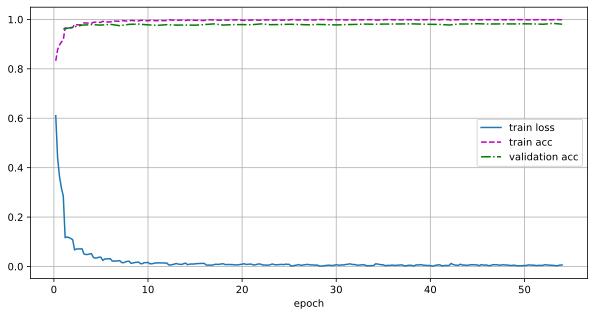

In [ ]:
network, params = get_network_and_params('lenet')
train(network, 'lenet', params, 'mnist')

**(f) Does the training converge? How well does your network perform?**

Yes, for the `conv-4` network and the `cifar-10` dataset, the training converges at around 25 epochs. The accuracy is high (around 90 percent).

for the `lenet` network and the `mnist` dataset, the training converges at around 10 epochs and the accuracy is very high (around 99 percent).



**(g) Re-train the same network, with the same initial weights. Are the results the same?**

loss 0.007, train acc 0.999, test acc 0.986
29931020.8 examples/sec on cuda:0


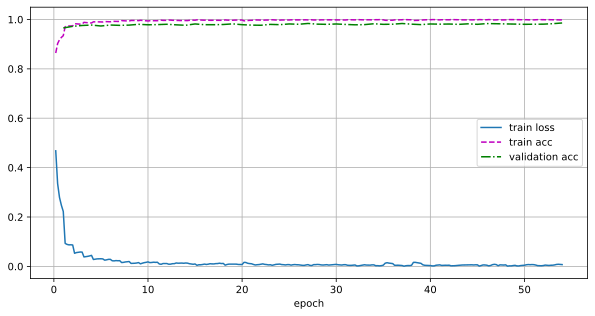

In [ ]:
network.apply(init_weights)
train(network, 'lenet', params, 'mnist')

Yes, the results are similar, as can be seen from the training graph.

**(h) The paper uses a variant of 'early stopping'. How is this done? Implement it in your training loop.**

Hint: A simple way to keep track of the best model is to create a model checkpoint in a file `"checkpoints/model-...-best.pth"`

The variant of 'early stopping' used is the iteration of minimum validation loss. This is done by identifying the common pattern for validation and test lost during training, then define the criterion to calculate minimum validation loss.

## 7.4 Pruning

Hint:
Pruning is implemented already in PyTorch, in the module [torch.utils.prune](https://pytorch.org/docs/stable/nn.html#module-torch.nn.utils).
The pruning method used in the paper corresponds is called [L1Unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.L1Unstructured.html#torch.nn.utils.prune.L1Unstructured) in PyTorch.

**(a) The PyTorch pruning function accepts an amount to prune. Is that the amount of weights to set to 0 or the amount to keep nonzero? Is the paper using the same?**

It's the amount to keep nonzero (the value is a float between .0 and 1.)
Yes, the paper is using the same.

**(b) Define a function to prune a network as used in the paper. It should take an amount to prune as an argument. Should all parameters be pruned or only weights?**

Note: is the pruning rate the same for all types of layers?

Hint: for a `Sequential` layer, you can access the layers as `net.children()`. For a layer, you can use `isinstance(layer, torch.nn.Linear)` to check if it is a linear layer.

Only weight should be pruned, that is mentioned in the Lottery Winning Ticket algorithm. " We identify a winning ticket by training a network and pruning its
smallest-magnitude weights"

**(c) Check your pruning function on a very simple neural network. Print the network parameters before and after pruning to make sure you understand what is going on.**

In [ ]:
sample_net = torch.nn.Sequential(
    torch.nn.Linear(3, 4),
    torch.nn.Linear(4, 5)
)

print("---Before pruning---")
print("--params before--")
for name, params in sample_net.named_parameters():
    print(name, params)

# Prune
prune_network_sequential(0.5, sample_net, 'l1')

print("---After Pruning---")
print("--params after--")
for name, params in sample_net.named_parameters():
    print(name, params)
print("--buffers after--")
for name, buffers in sample_net.named_buffers():
    print(name, buffers)
print("--weight after--")
for i in range(len(sample_net)):
    print(sample_net[i].weight)

---Before pruning---
--params before--
0.weight Parameter containing:
tensor([[ 0.2515,  0.1165, -0.5653],
        [-0.3531,  0.4732,  0.2201],
        [ 0.4374,  0.1265,  0.4902],
        [ 0.2274,  0.2987,  0.4125]], requires_grad=True)
0.bias Parameter containing:
tensor([-0.5278,  0.5206, -0.2553,  0.3095], requires_grad=True)
1.weight Parameter containing:
tensor([[ 0.4859, -0.2759,  0.4525, -0.1007],
        [-0.0063, -0.4551, -0.0233,  0.3741],
        [-0.3532,  0.0340,  0.3627, -0.4875],
        [ 0.1403,  0.3478,  0.0470, -0.1617],
        [ 0.3906,  0.2971,  0.2061,  0.0121]], requires_grad=True)
1.bias Parameter containing:
tensor([-0.3988, -0.4745,  0.0963, -0.2129,  0.0330], requires_grad=True)
---After Pruning---
--params after--
0.bias Parameter containing:
tensor([-0.5278,  0.5206, -0.2553,  0.3095], requires_grad=True)
0.weight_orig Parameter containing:
tensor([[ 0.2515,  0.1165, -0.5653],
        [-0.3531,  0.4732,  0.2201],
        [ 0.4374,  0.1265,  0.4902],
    

**(d) Define a function that applies the pruning mask from a pruned network to another network of the same architecture.**

This function should only do pruning (so some weights become 0), other weights should remain the same.

Hint: the pruning functions already generate and store pruning masks. You should be able to extract these from a pruned network.

Hint 2: `custom_from_mask`

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(e) Check your mask copy function on a very simple neural network. Check that only the pruning mask is copied.**

In [ ]:
tobe_copied = torch.nn.Sequential(
    torch.nn.Linear(3, 4),
    torch.nn.Linear(4, 5)
)

print("---Before Copying---")
print("--buffers of pruned--")
for name, buffers in sample_net.named_buffers():
    print(name, buffers)

copy_pruning_mask(tobe_copied, sample_net)

print("---After Copying---")

print("--buffers after--")
for name, buffers in tobe_copied.named_buffers():
    print(name, buffers)

---Before Copying---
--buffers of pruned--
0.weight_mask tensor([[0., 0., 1.],
        [1., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]])
1.weight_mask tensor([[1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.]])
---After Copying---
--buffers after--
0.weight_mask tensor([[0., 0., 1.],
        [1., 1., 0.],
        [1., 0., 1.],
        [0., 0., 1.]])
1.weight_mask tensor([[1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.]])


**(f) Define a function that randomly prunes a network.**

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

I already did that in 7.4b.

**(g) Check the above function.**

In [ ]:
sample_net = torch.nn.Sequential(
    torch.nn.Linear(3, 4),
    torch.nn.Linear(4, 5)
)

print("---Before pruning---")
print("--params before--")
for name, params in sample_net.named_parameters():
    print(name, params)

# Prune
prune_network_sequential(0.5, sample_net, 'random')

print("---After Pruning---")
print("--params after--")
for name, params in sample_net.named_parameters():
    print(name, params)
print("--buffers after--")
for name, buffers in sample_net.named_buffers():
    print(name, buffers)

---Before pruning---
--params before--
0.weight Parameter containing:
tensor([[-0.1896,  0.0911, -0.0737],
        [ 0.2163, -0.2534, -0.5317],
        [ 0.1506, -0.1028, -0.4850],
        [-0.4158, -0.1259, -0.3367]], requires_grad=True)
0.bias Parameter containing:
tensor([-0.0549, -0.0887, -0.1204, -0.0215], requires_grad=True)
1.weight Parameter containing:
tensor([[-0.1710,  0.1532, -0.2800, -0.2991],
        [ 0.0980,  0.2259, -0.0486,  0.1553],
        [ 0.4274,  0.1329,  0.1664, -0.2229],
        [-0.0914, -0.1669,  0.0301,  0.3862],
        [ 0.1896, -0.4512, -0.2102,  0.2774]], requires_grad=True)
1.bias Parameter containing:
tensor([-0.0438, -0.1798, -0.3368,  0.1821,  0.4552], requires_grad=True)
---After Pruning---
--params after--
0.bias Parameter containing:
tensor([-0.0549, -0.0887, -0.1204, -0.0215], requires_grad=True)
0.weight_orig Parameter containing:
tensor([[-0.1896,  0.0911, -0.0737],
        [ 0.2163, -0.2534, -0.5317],
        [ 0.1506, -0.1028, -0.4850],
    

**(h) Define a function that performs the experiment described in Section 1 of the paper on a given dataset and with a given architecture**

Save all needed results to a file, such as test loss and accuracy. This will make your job easier later on.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

## 7.5 Experiments from Section 1

**(a) Perform the experiments needed to reproduce the red line in Figure 1 from the paper**

Hint: create a python script (`experiment1-{dataset}.py`) that does all the training as needed.
Then load the checkpoint files and do your analysis here.
You may also want to define more helper functions.

Hint 2: look at previous assignments for how to plot. See also [documentation for `plt.errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html).

TODO: Training implemented in `TODO.py`

In [ ]:
section1_oneshot('mnist', 'lenet', 1, 0.2, 'l1', "lenet/train_results_iteration_lenet.txt")
section1_oneshot('mnist', 'lenet', 2, 0.589, 'l1', "lenet/train_results_iteration_lenet.txt")
section1_oneshot('mnist', 'lenet', 3, 0.831, 'l1', "lenet/train_results_iteration_lenet.txt")
section1_oneshot('mnist', 'lenet', 4, 0.93, 'l1', "lenet/train_results_iteration_lenet.txt")

loss 0.007, train acc 0.998, test acc 0.982
30136145.8 examples/sec on cuda:0
loss 0.003, train acc 0.999, test acc 0.980
27940867.2 examples/sec on cuda:0
loss 0.003, train acc 0.999, test acc 0.981
30698781.0 examples/sec on cuda:0
loss 0.000, train acc 1.000, test acc 0.984
28204694.5 examples/sec on cuda:0
loss 0.004, train acc 0.999, test acc 0.979
30645204.8 examples/sec on cuda:0
loss 0.000, train acc 1.000, test acc 0.982
28246999.1 examples/sec on cuda:0
loss 0.005, train acc 0.999, test acc 0.979
30812954.0 examples/sec on cuda:0
loss 0.000, train acc 1.000, test acc 0.976
28134447.2 examples/sec on cuda:0


In [ ]:
section1_oneshot('mnist', 'lenet', 5, 0.2, 'random', "lenet/train_results_iteration_lenet_random.txt")
section1_oneshot('mnist', 'lenet', 6, 0.589, 'random', "lenet/train_results_iteration_lenet_random.txt")
section1_oneshot('mnist', 'lenet', 7, 0.831, 'random', "lenet/train_results_iteration_lenet_random.txt")
section1_oneshot('mnist', 'lenet', 8, 0.93, 'random', "lenet/train_results_iteration_lenet_random.txt")

loss 0.005, train acc 0.999, test acc 0.980
30799578.5 examples/sec on cuda:0
loss 0.003, train acc 0.999, test acc 0.983
28270000.3 examples/sec on cuda:0
loss 0.006, train acc 0.998, test acc 0.984
30792937.3 examples/sec on cuda:0
loss 0.002, train acc 1.000, test acc 0.980
28420581.6 examples/sec on cuda:0
loss 0.003, train acc 0.999, test acc 0.981
30895267.1 examples/sec on cuda:0
loss 0.011, train acc 0.997, test acc 0.976
28382314.2 examples/sec on cuda:0
loss 0.003, train acc 0.999, test acc 0.982
31105857.4 examples/sec on cuda:0
loss 0.004, train acc 0.999, test acc 0.965
28750365.7 examples/sec on cuda:0


In [ ]:
!cp -r "/content/lenet" "/content/drive/MyDrive/"

Plot the graphs

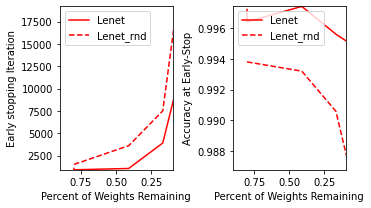

In [ ]:
percent_weight_remaining = []
early_stopping_iter = []
val_accs = []

percent_weight_remaining_random = []
early_stopping_iter_random = []
val_accs_random = []
with open('lenet/train_results_iteration_lenet.txt') as input_data:
    prevLine = ""
    for line in input_data:
        if "Writing" in line:
            per, it = map(float, prevLine.split(","))
            percent_weight_remaining.append(per)
            early_stopping_iter.append(it)
            next_line = next(input_data)
            per, val_acc = map(float, next_line.split(","))
            val_accs.append(val_acc)
        prevLine = line
    input_data.close()
with open('lenet/train_results_iteration_lenet_random.txt') as input_data:
    prevLine = ""
    for line in input_data:
        if "Writing" in line:
            per, it = map(float, prevLine.split(","))
            percent_weight_remaining_random.append(per)
            early_stopping_iter_random.append(it)
            next_line = next(input_data)
            per, val_acc = map(float, next_line.split(","))
            val_accs_random.append(val_acc)
        prevLine = line
    input_data.close()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

ax1.errorbar(percent_weight_remaining, early_stopping_iter,
             label ='Lenet', color='red')

ax1.errorbar(percent_weight_remaining_random, early_stopping_iter_random,
             label ='Lenet_rnd', color='red', linestyle ='dashed')
ax1.set_xlabel('Percent of Weights Remaining')
ax1.set_ylabel('Early stopping Iteration')
combi = early_stopping_iter + early_stopping_iter_random
y_min = np.min(combi)
y_max = np.max(combi)
ax1.axis([0.9, 0.1, y_min, y_max])
ax1.legend(loc ='upper left')

ax2.errorbar(percent_weight_remaining, val_accs,
             label ='Lenet', color='red')

ax2.errorbar(percent_weight_remaining_random, val_accs_random,
             label ='Lenet_rnd', color='red', linestyle ='dashed')
combi = val_accs + val_accs_random
y_min = np.min(combi)
y_max = np.max(combi)
ax2.axis([0.9, 0.1, y_min, y_max])
ax2.set_xlabel('Percent of Weights Remaining')
ax2.set_ylabel('Accuracy at Early-Stop')
ax2.legend(loc ='upper left')
fig.tight_layout()

**(b) Do your results match the paper? Discuss similarities and differences**

My result is somewhat similar to the paper, the subnetwork pruned by random method has less accuracy at early stop and fluctuates more than the subnetwork pruned by `l1_unstructured`.

**(c) Perform the experiments needed to reproduce the rest of Figure 1 from the paper**

Hint: create a python script (`experiment1-{dataset}.py`). Try to avoid duplicating code, by moving common things into function in the `dl_assignment_7_common.py` file.

TODO: Training implemented in `TODO.py`

Training Conv-2

In [ ]:
section1_oneshot('cifar10', 'conv-2', 1, 0.2, 'l1', "conv-2/train_results_iteration_conv-2.txt")
section1_oneshot('cifar10', 'conv-2', 2, 0.588, 'l1', "conv-2/train_results_iteration_conv-2.txt")
section1_oneshot('cifar10', 'conv-2', 3, 0.83, 'l1', "conv-2/train_results_iteration_conv-2.txt")
section1_oneshot('cifar10', 'conv-2', 4, 0.929, 'l1', "conv-2/train_results_iteration_conv-2.txt")

In [ ]:
section1_oneshot('cifar10', 'conv-2', 5, 0.2, 'random', "conv-2/train_results_iteration_conv-2_random.txt")
section1_oneshot('cifar10', 'conv-2', 6, 0.588, 'random', "conv-2/train_results_iteration_conv-2_random.txt")
section1_oneshot('cifar10', 'conv-2', 7, 0.83, 'random', "conv-2/train_results_iteration_conv-2_random.txt")
section1_oneshot('cifar10', 'conv-2', 8, 0.929, 'random', "conv-2/train_results_iteration_conv-2_random.txt")

Training Conv-4

In [ ]:
section1_oneshot('cifar10', 'conv-4', 1, 0.2, 'l1', "conv-4/train_results_iteration_conv-4.txt")
section1_oneshot('cifar10', 'conv-4', 2, 0.588, 'l1', "conv-4/train_results_iteration_conv-4.txt")
section1_oneshot('cifar10', 'conv-4', 3, 0.83, 'l1', "conv-4/train_results_iteration_conv-4.txt")
section1_oneshot('cifar10', 'conv-4', 4, 0.929, 'l1', "conv-4/train_results_iteration_conv-4.txt")

Files already downloaded and verified
Files already downloaded and verified
loss 1.636, train acc 0.825, test acc 0.651
3879034.3 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.604, train acc 0.857, test acc 0.709
3783066.6 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
loss 1.712, train acc 0.724, test acc 0.556
3883619.3 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.604, train acc 0.843, test acc 0.639
3790191.9 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
loss 1.623, train acc 0.840, test acc 0.681
3884334.0 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.

In [ ]:
section1_oneshot('cifar10', 'conv-4', 5, 0.2, 'random', "conv-4/train_results_iteration_conv-4_random.txt")
section1_oneshot('cifar10', 'conv-4', 6, 0.588, 'random', "conv-4/train_results_iteration_conv-4_random.txt")
section1_oneshot('cifar10', 'conv-4', 7, 0.83, 'random', "conv-4/train_results_iteration_conv-4_random.txt")
section1_oneshot('cifar10', 'conv-4', 8, 0.929, 'random', "conv-4/train_results_iteration_conv-4_random.txt")

Files already downloaded and verified
Files already downloaded and verified
loss 1.561, train acc 0.901, test acc 0.705
3881716.2 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.521, train acc 0.940, test acc 0.715
3784252.1 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
loss 1.641, train acc 0.809, test acc 0.636
3889328.7 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.620, train acc 0.829, test acc 0.642
3789968.4 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
loss 1.624, train acc 0.837, test acc 0.682
3883877.6 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.

Training Conv-6

In [ ]:
section1_oneshot('cifar10', 'conv-6', 1, 0.2, 'l1', "conv-6/train_results_iteration_conv-6.txt")
section1_oneshot('cifar10', 'conv-6', 2, 0.588, 'l1', "conv-6/train_results_iteration_conv-6.txt")
section1_oneshot('cifar10', 'conv-6', 3, 0.83, 'l1', "conv-6/train_results_iteration_conv-6.txt")
section1_oneshot('cifar10', 'conv-6', 4, 0.929, 'l1', "conv-6/train_results_iteration_conv-6.txt")

Files already downloaded and verified
Files already downloaded and verified
loss 1.654, train acc 0.807, test acc 0.635
3199091.5 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.641, train acc 0.820, test acc 0.637
3174258.8 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
loss 1.639, train acc 0.816, test acc 0.670
3201523.0 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.605, train acc 0.845, test acc 0.677
3176638.5 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
loss 1.560, train acc 0.901, test acc 0.751
3203834.5 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.

In [ ]:
section1_oneshot('cifar10', 'conv-6', 5, 0.2, 'random', "conv-6/train_results_iteration_conv-6_random.txt")
section1_oneshot('cifar10', 'conv-6', 6, 0.588, 'random', "conv-6/train_results_iteration_conv-6_random.txt")
section1_oneshot('cifar10', 'conv-6', 7, 0.83, 'random', "conv-6/train_results_iteration_conv-6_random.txt")
section1_oneshot('cifar10', 'conv-6', 8, 0.929, 'random', "conv-6/train_results_iteration_conv-6_random.txt")

Files already downloaded and verified
Files already downloaded and verified
loss 1.575, train acc 0.886, test acc 0.717
3198887.9 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.530, train acc 0.931, test acc 0.743
3170894.7 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
loss 1.629, train acc 0.832, test acc 0.693
3193340.5 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.589, train acc 0.864, test acc 0.698
3170547.7 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
loss 1.581, train acc 0.880, test acc 0.707
3194430.9 examples/sec on cuda:0
Files already downloaded and verified
Files already downloaded and verified
loss 1.

In [ ]:
!cp -r "/content/conv-2" "/content/drive/MyDrive/"
!cp -r "/content/conv-4" "/content/drive/MyDrive/"
!cp -r "/content/conv-6" "/content/drive/MyDrive/"

Plots for `Conv-2`, `Conv-4` and `Conv-6` networks

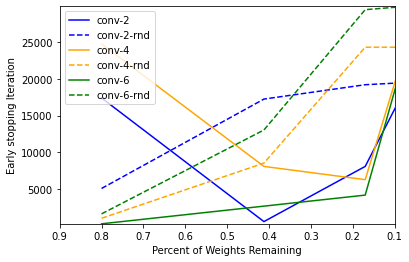

In [ ]:
# Conv-2
percent_weight_remaining_conv2 = []
early_stopping_iter_conv2 = []
val_accs_conv2 = []

percent_weight_remaining_conv2_random = []
early_stopping_iter_conv2_random = []
val_accs_conv2_random = []

# Conv-4
percent_weight_remaining_conv4 = []
early_stopping_iter_conv4 = []
val_accs_conv4 = []

percent_weight_remaining_conv4_random = []
early_stopping_iter_conv4_random = []
val_accs_conv4_random = []

# Conv-6
percent_weight_remaining_conv6 = []
early_stopping_iter_conv6 = []
val_accs_conv6 = []

percent_weight_remaining_conv6_random = []
early_stopping_iter_conv6_random = []
val_accs_conv6_random = []

with open('conv-2/train_results_iteration_conv-2.txt') as input_data:
    prevLine = ""
    for line in input_data:
        if "Writing" in line:
            per, it = map(float, prevLine.split(","))
            percent_weight_remaining_conv2.append(per)
            early_stopping_iter_conv2.append(it)
            next_line = next(input_data)
            per, val_acc = map(float, next_line.split(","))
            val_accs_conv2.append(val_acc)
        prevLine = line
    input_data.close()

with open('conv-2/train_results_iteration_conv-2_random.txt') as input_data:
    prevLine = ""
    for line in input_data:
        if "Writing" in line:
            per, it = map(float, prevLine.split(","))
            percent_weight_remaining_conv2_random.append(per)
            early_stopping_iter_conv2_random.append(it)
            next_line = next(input_data)
            per, val_acc = map(float, next_line.split(","))
            val_accs_conv2_random.append(val_acc)
        prevLine = line
    input_data.close()

with open('conv-4/train_results_iteration_conv-4.txt') as input_data:
    prevLine = ""
    for line in input_data:
        if "Writing" in line:
            per, it = map(float, prevLine.split(","))
            percent_weight_remaining_conv4.append(per)
            early_stopping_iter_conv4.append(it)
            next_line = next(input_data)
            per, val_acc = map(float, next_line.split(","))
            val_accs_conv4.append(val_acc)
        prevLine = line
    input_data.close()

with open('conv-4/train_results_iteration_conv-4_random.txt') as input_data:
    prevLine = ""
    for line in input_data:
        if "Writing" in line:
            per, it = map(float, prevLine.split(","))
            percent_weight_remaining_conv4_random.append(per)
            early_stopping_iter_conv4_random.append(it)
            next_line = next(input_data)
            per, val_acc = map(float, next_line.split(","))
            val_accs_conv4_random.append(val_acc)
        prevLine = line
    input_data.close()

with open('conv-6/train_results_iteration_conv-6.txt') as input_data:
    prevLine = ""
    for line in input_data:
        if "Writing" in line:
            per, it = map(float, prevLine.split(","))
            percent_weight_remaining_conv6.append(per)
            early_stopping_iter_conv6.append(it)
            next_line = next(input_data)
            per, val_acc = map(float, next_line.split(","))
            val_accs_conv6.append(val_acc)
        prevLine = line
    input_data.close()

with open('conv-6/train_results_iteration_conv-6_random.txt') as input_data:
    prevLine = ""
    for line in input_data:
        if "Writing" in line:
            per, it = map(float, prevLine.split(","))
            percent_weight_remaining_conv6_random.append(per)
            early_stopping_iter_conv6_random.append(it)
            next_line = next(input_data)
            per, val_acc = map(float, next_line.split(","))
            val_accs_conv6_random.append(val_acc)
        prevLine = line
    input_data.close()

plt.errorbar(percent_weight_remaining_conv2, early_stopping_iter_conv2,
             label ='conv-2', color='blue')

plt.errorbar(percent_weight_remaining_conv2_random, early_stopping_iter_conv2_random,
             label ='conv-2-rnd', color='blue', linestyle ='dashed')

plt.errorbar(percent_weight_remaining_conv4, early_stopping_iter_conv4,
             label ='conv-4', color='orange')

plt.errorbar(percent_weight_remaining_conv4_random, early_stopping_iter_conv4_random,
             label ='conv-4-rnd', color='orange', linestyle ='dashed')

plt.errorbar(percent_weight_remaining_conv6, early_stopping_iter_conv6,
             label ='conv-6', color='green')

plt.errorbar(percent_weight_remaining_conv6_random, early_stopping_iter_conv6_random,
             label ='conv-6-rnd', color='green', linestyle ='dashed')
combi = early_stopping_iter_conv2 + early_stopping_iter_conv4 + early_stopping_iter_conv6 + early_stopping_iter_conv2_random + early_stopping_iter_conv4_random + early_stopping_iter_conv6_random
y_max = np.max(combi)
y_min = np.min(combi)

plt.xlabel('Percent of Weights Remaining')
plt.ylabel('Early stopping Iteration')
plt.axis([0.9, 0.1, y_min, y_max])
plt.legend(loc ='upper left')

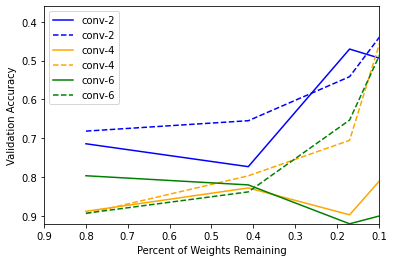

In [ ]:
plt.errorbar(percent_weight_remaining_conv2, val_accs_conv2,
             label ='conv-2', color='blue')

plt.errorbar(percent_weight_remaining_conv2_random, val_accs_conv2_random,
             label ='conv-2', color='blue', linestyle ='dashed')

plt.errorbar(percent_weight_remaining_conv4, val_accs_conv4,
             label ='conv-4', color='orange')

plt.errorbar(percent_weight_remaining_conv4_random, val_accs_conv4_random,
             label ='conv-4', color='orange', linestyle ='dashed')

plt.errorbar(percent_weight_remaining_conv6, val_accs_conv6,
             label ='conv-6', color='green')

plt.errorbar(percent_weight_remaining_conv6_random, val_accs_conv6_random,
             label ='conv-6', color='green', linestyle ='dashed')
combi = val_accs_conv2 + val_accs_conv4 + val_accs_conv6 + val_accs_conv2_random + val_accs_conv4_random + val_accs_conv6_random
y_max = np.max(combi)
y_min = np.min(combi)
plt.xlabel('Percent of Weights Remaining')
plt.ylabel('Validation Accuracy')
plt.axis([0.9, 0.1, y_max, y_min])
plt.legend(loc ='upper left')

**(d) Do your results match the paper? Discuss similarities and differences**

For the iteration at Early-stopping graph, it's similar, the lines follow the pattern of increasing iterations when the the percentage of unpruned weights gets lower, and the random pruned networks have higher iterations.

For the other graph, the graph is also similar, when the random pruned network generally have lower validation accuracy.

**(e) What can you conclude from this experiment?**

I don't have enough time and resources to do five and ten trials for both training the winning tickets and the randomly pruned network, respectively. Some of my outcome graphs match the figure in the paper, some don't so I believe I recreated a part of this paper.

## 7.6 Experiments from Section 2

**(a) What is the difference between the experiment in Figure 1 and Figure 3 of the paper.**

Hint: are there differences in the method, the architecture, or the dataset

*   Figure 1 uses one-shot pruning, figure 3 uses iterative pruning
*   The convolutional networks in Figure 3 aren't run and plotted
*   Figure 1 measues validation accuracy, figure 3 measures test accuracy



**(b) Implement the iterative pruning method from the paper**

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(c) Perform the experiments needed to reproduce Figure 3 from the paper**

Hint: see previous section

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here
remaining_weight_1,_ = section2_iterative('mnist', 'lenet', 1, 0.4, 5, 'l1', 'lenet/train_results_iteration_lenet_fig3.txt')
remaining_weight_2,_ = section2_iterative('mnist', 'lenet', 1, 0.58, 5, 'l1', 'lenet/train_results_iteration_lenet_fig3.txt')
remaining_weight_3,_ = section2_iterative('mnist', 'lenet', 1, 0.65, 5, 'l1', 'lenet/train_results_iteration_lenet_fig3.txt')


loss 0.009, train acc 0.997, test acc 0.981
68202831.9 examples/sec on cuda:0
loss 0.005, train acc 0.998, test acc 0.982
61923460.9 examples/sec on cuda:0
loss 0.006, train acc 0.998, test acc 0.982
62055850.1 examples/sec on cuda:0
loss 0.003, train acc 0.999, test acc 0.981
62332510.9 examples/sec on cuda:0
loss 0.004, train acc 0.999, test acc 0.982
62459640.5 examples/sec on cuda:0
loss 0.005, train acc 0.998, test acc 0.982
62751096.7 examples/sec on cuda:0
loss 0.011, train acc 0.997, test acc 0.978
68903252.2 examples/sec on cuda:0
loss 0.005, train acc 0.999, test acc 0.981
62545708.5 examples/sec on cuda:0
loss 0.003, train acc 0.999, test acc 0.982
62259740.7 examples/sec on cuda:0
loss 0.000, train acc 1.000, test acc 0.985
62509515.2 examples/sec on cuda:0
loss 0.000, train acc 1.000, test acc 0.984
62437034.3 examples/sec on cuda:0
loss 0.000, train acc 1.000, test acc 0.984
61928664.8 examples/sec on cuda:0
loss 0.008, train acc 0.997, test acc 0.980
68569751.0 examples/

In [ ]:
!cp -r "/content/lenet" "/content/drive/MyDrive/"

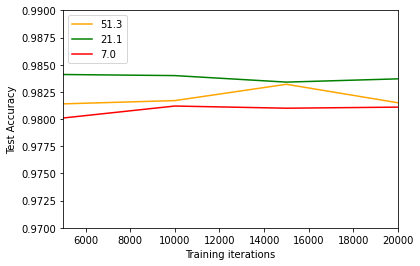

In [ ]:
training_iters = []
test_accs = []

with open('lenet/train_results_iteration_lenet_fig3.txt') as input_data:
     for line in input_data:
        if line.strip() == '------------------':
            continue
        test_acc, it = map(float, line.split(","))
        test_accs.append(test_acc)
        training_iters.append(it)
     input_data.close()

iters1, accs1 = training_iters[:4], test_accs[:4]
iters2, accs2 = training_iters[4:8], test_accs[4:8]
iters3, accs3 = training_iters[8:], test_accs[8:]

plt.errorbar(iters1, accs1,
             label ="51.3", color='orange')

plt.errorbar(iters2, accs2,
             label ="21.1", color='green')

plt.errorbar(iters3, accs3,
             label ="7.0", color='red')

plt.xlabel('Training iterations')
plt.ylabel('Test Accuracy')
plt.axis([5000, 20000, 0.97, 0.99])
plt.legend(loc ='upper left')

**(d) Do your results match the paper? Discuss similarities and differences**

My resultant graph is similar to figure 3 in the paper. The test accuracy falls around 0.98 for each of the pruning amount. I didn't have time to do the iterative pruning for all the amounts in figure 3, therefore I could only plot one graph with each of the lines from the figure's 3 graphs.

**(e) Perform the experiments needed to reproduce Figure 4 from the paper**

Hint: see previous section

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here
figure4('mnist', 'lenet', 1, 0.487, 5, 'lenet/train_results_combination_1.txt')
figure4('mnist', 'lenet', 1, 0.789, 5, 'lenet/train_results_combination_2.txt')
figure4('mnist', 'lenet', 1, 0.93, 5, 'lenet/train_results_combination_3.txt')
figure4('mnist', 'lenet', 1, 0.964, 5, 'lenet/train_results_combination_4.txt')

KeyboardInterrupt: ignored

In [ ]:
!cp -r "/content/lenet" "/content/drive/MyDrive/"

**(f) Do your results match the paper? Discuss similarities and differences**

I left my code for figure 4 run overnight, but the runtime was disconnected and it couldn't save the results file in my Drive, therefore, I could not make any plot for figure 4 in time.

**(g) What can you conclude from this experiment?**

Iterative pruning and random initialization, when implemented correctly, are effective ways to improve the winning ticket on both train, test and validation accuracy.

## 7.7 Experiments from Section 3

**(a) Perform the experiments needed to reproduce Figure 5 from the paper**

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(b) Do your results match the paper? Discuss similarities and differences**

TODO: your answer here.

**(c) Perform the experiments needed to reproduce Figure 6 from the paper**

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(d) Do your results match the paper? Discuss similarities and differences**

TODO: your answer here.

**(e) What can you conclude from this experiment? Is network depth related to how well the pruning works?**

TODO: your answer here.

## 7.8 Experiments from Section 4

**(a) Section 4 of the paper describes a slightly different pruning method. Implement that method below**

Hint: look at [`torch.nn.utils.prune.global_unstructured`](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.global_unstructured.html) and at the examples on that page.

If you get stuck on this step, feel free to continue on with the same pruning methods as before.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(b) Perform the experiments needed to reproduce Figure 7 from the paper**

Note: this will be computationally more expensive.

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(c) Do your results match the paper? Discuss similarities and differences**

TODO: your answer here.

**(d) Perform the experiments needed to reproduce Figure 8 from the paper**

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(e) Do your results match the paper? Discuss similarities and differences**

TODO: your answer here.

## 7.9 Beyond the paper (optional)

Here are some ideas to continue beyond the paper.
These questions are optional, and you are free to come up with your own ideas.

### Speech data
Does the lottry ticket hypothesis also work on other types of data, for example speech?

Repeat the experiments and compare the results.

Hint: keep the dataset to a reasonable size.

### Other architectures
The paper has experimented with fully connected and convolutional networks.
Can you extend this experiment to other architectures, such as RNNs or transformers?

Hint: you may need to consider a different type of data

Hint 2: keep the networks simple, just like what was done in the paper

### Other aspects
In the appendices, the paper considers many aspects of neural networks, such as dataset size, model size, hyperparameters etc. Pick one of these experiments and reproduce it. Feel free to give it your own twist.

**(a) Describe the experiment that you want to perform.**

TODO: your answer here.

**(b) What result do you expect?**

TODO: your answer here.

**(c) Perform the experiments needed to make a conclusion.**

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(d) What can you conclude from this experiment?**

TODO: your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.